In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [2]:
Sdata = pd.read_csv('ProcessedStandardised.csv',';')
NSdata = pd.read_csv('ProcessedNonStandardised.csv',';')

In [3]:
#Filtering
TickerChoice = "'HCI'"
SdataGDO = Sdata[NSdata.Ticker == TickerChoice]
print(SdataGDO)

     DateStamps  Shares Ticker  RETURNT1  Returns  BetatoJ203  BetatoRBAS  \
35   2006/11/30       6  'HCI'      0.03     1.93       -0.48       -2.71   
36   2006/12/29       6  'HCI'     -0.10     0.03       -0.32       -2.45   
37   2007/01/31       6  'HCI'     -0.79    -0.10       -0.23       -2.51   
38   2007/02/28       6  'HCI'     -0.26    -0.79       -0.26       -2.37   
39   2007/03/30       6  'HCI'     -0.31    -0.26       -0.56       -2.33   
..          ...     ...    ...       ...      ...         ...         ...   
159  2017/04/28       6  'HCI'     -0.09    -0.09        0.66       -0.95   
160  2017/05/31       6  'HCI'      0.44    -0.09        0.57       -0.92   
161  2017/06/30       6  'HCI'     -0.81     0.44        0.45       -0.97   
162  2017/07/31       6  'HCI'      0.41    -0.81        0.24       -0.72   
163  2017/08/31       6  'HCI'     -0.29     0.41        0.31       -0.74   

     BetatoRLRS  DebttoEquity  DebttoEquityTrend  BookvaluetoPriceTrend  \


In [4]:
#NS_GDO = NSdataGDO[['A', 'C', 'D']].copy()

S_GDO = SdataGDO.copy() 
S_GDO.drop(["DateStamps", "Shares", "Ticker"], axis = 1, inplace = True)

print(S_GDO)

     RETURNT1  Returns  BetatoJ203  BetatoRBAS  BetatoRLRS  DebttoEquity  \
35       0.03     1.93       -0.48       -2.71       -1.70         -0.43   
36      -0.10     0.03       -0.32       -2.45       -1.73         -0.43   
37      -0.79    -0.10       -0.23       -2.51       -1.72         -0.43   
38      -0.26    -0.79       -0.26       -2.37       -1.55         -0.44   
39      -0.31    -0.26       -0.56       -2.33       -1.63         -0.44   
..        ...      ...         ...         ...         ...           ...   
159     -0.09    -0.09        0.66       -0.95        0.21         -0.34   
160      0.44    -0.09        0.57       -0.92        0.27         -0.38   
161     -0.81     0.44        0.45       -0.97        0.33         -0.37   
162      0.41    -0.81        0.24       -0.72        0.31         -0.37   
163     -0.29     0.41        0.31       -0.74        0.30         -0.37   

     DebttoEquityTrend  BookvaluetoPriceTrend  CashflowtoPrice  \
35               -0.6

IndexError: index 11 is out of bounds for axis 0 with size 11

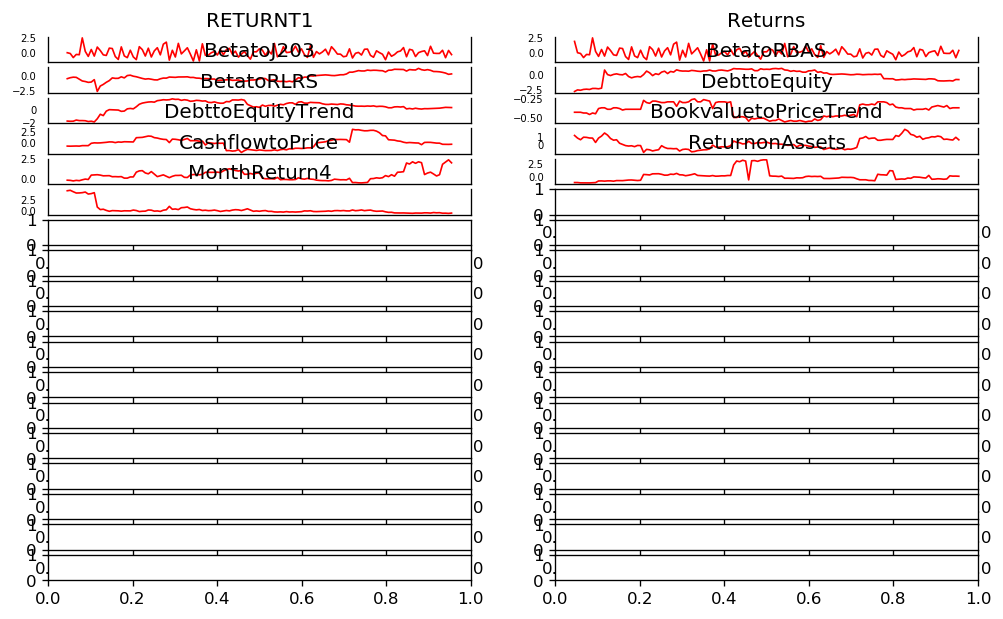

In [5]:
# 2. Visualize the time series for each feature

# Plot.

fid, axes = plt.subplots(nrows=18, ncols=2, dpi=120, figsize=(10, 6))
i=3

for i, ax in enumerate(axes.flatten()):
    data = S_GDO[S_GDO.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    
    # Decorations
    ax.set_title(S_GDO.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)
    
plt.tight_layout()

In [6]:
# 3. Testing Causation using Grangers' Causality Test

# Using Granger’s Causality Test, it’s possible to test this relationship between variables before even building the model.
# Granger’s causality tests the null hypothesis that the coefficients of past values in the regression equation is zero.
# In simpler terms, the past values of time series (X) do not cause the other series (Y).
# So, if the p-value obtained from the test is lesser than the significance level of 0.05, then, you can safely reject the null hypothesis.


from statsmodels.tsa.stattools import grangercausalitytests

maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(S_GDO, variables = S_GDO.columns)

,RETURNT1_x,Returns_x,BetatoJ203_x,BetatoRBAS_x,BetatoRLRS_x,DebttoEquity_x,DebttoEquityTrend_x,BookvaluetoPriceTrend_x,CashflowtoPrice_x,ReturnonAssets_x,MonthReturn4_x
RETURNT1_y,1.0000,0.1626,0.1251,0.0815,0.1427,0.0811,0.1132,0.0201,0.4792,0.1131,0.0084
Returns_y,0.0000,1.0000,0.1348,0.0633,0.1042,0.1489,0.3268,0.0159,0.5305,0.2170,0.0089
BetatoJ203_y,0.0411,0.0016,1.0000,0.0000,0.0015,0.1009,0.1137,0.1134,0.0000,0.0067,0.0000
BetatoRBAS_y,0.0136,0.0082,0.0000,1.0000,0.0083,0.0191,0.1802,0.0223,0.3959,0.3562,0.0000
BetatoRLRS_y,0.0139,0.0051,0.0000,0.0000,1.0000,0.2316,0.6145,0.0001,0.4119,0.0003,0.0000
DebttoEquity_y,0.1525,0.1562,0.1494,0.2625,0.6425,1.0000,0.1027,0.7242,0.6193,0.0533,0.3801
DebttoEquityTrend_y,0.2640,0.0871,0.4492,0.7247,0.6513,0.0099,1.0000,0.3430,0.1408,0.0587,0.6328
BookvaluetoPriceTrend_y,0.0000,0.0001,0.0257,0.0135,0.0272,0.1607,0.1240,1.0000,0.5280,0.5948,0.0598
CashflowtoPrice_y,0.4184,0.2152,0.1349,0.1085,0.0364,0.0500,0.0240,0.0135,1.0000,0.0132,0.8540
ReturnonAssets_y,0.7616,0.5929,0.4505,0.0468,0.0189,0.0035,0.1113,0.1340,0.2439,1.0000,0.3056


In [7]:
# 4. Cointegration Test

# Cointegration test helps to establish the presence of a statistically significant connection between two or more time series.
# Order of integration(d) is nothing but the number of differencing required to make a non-stationary time series stationary.

# Now, when you have two or more time series,
# and there exists a linear combination of them that has an order of integration (d) < than that of the individual series,
# then the collection of series is said to be cointegrated.

# When two or more time series are cointegrated, it means they have a long run, statistically significant relationship.
# This is the basic premise on which Vector Autoregression(VAR) models is based on.

from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(S_GDO, alpha=0.05)

LinAlgError: Matrix is not positive definite

In [8]:
# 5. Split the Series into Training and Testing Data

# The VAR model will be fitted on df_train and then used to forecast the next 4 observations.
# These forecasts will be compared against the actuals present in test data.

nobs = 4

df_train = S_GDO[:-nobs]

print(df_train)

print('\n')

df_test = S_GDO[-nobs:]
print(df_test)

     RETURNT1  Returns  BetatoJ203  BetatoRBAS  BetatoRLRS  DebttoEquity  \
35       0.03     1.93       -0.48       -2.71       -1.70         -0.43   
36      -0.10     0.03       -0.32       -2.45       -1.73         -0.43   
37      -0.79    -0.10       -0.23       -2.51       -1.72         -0.43   
38      -0.26    -0.79       -0.26       -2.37       -1.55         -0.44   
39      -0.31    -0.26       -0.56       -2.33       -1.63         -0.44   
..        ...      ...         ...         ...         ...           ...   
155     -0.45     0.35        1.02       -0.67        0.13         -0.35   
156      1.11    -0.45        0.91       -0.93        0.15         -0.34   
157     -0.05     1.11        0.71       -0.96        0.16         -0.35   
158     -0.09    -0.05        0.70       -0.97        0.20         -0.36   
159     -0.09    -0.09        0.66       -0.95        0.21         -0.34   

     DebttoEquityTrend  BookvaluetoPriceTrend  CashflowtoPrice  \
35               -0.6

In [9]:
# 6. Check for Stationarity and Make the Time Series Stationary

# A stationary time series is one whose characteristics like mean and variance does not change over time.

# How to test for stationarity?
# There is a suite of tests called unit-root tests. The popular ones are:
# 1.) Augmented Dickey-Fuller Test (ADF Test)
# 2.) KPSS test
# 3.) Philip-Perron test

# If a series is found to be non-stationary, you make it stationary by differencing the series once and repeat the test again until it becomes stationary.

# NOTE:
# Differencing reduces the length of the series by 1
# all the time series have to be of the same length
# THUS, you need to difference all the series in the system if you choose to difference at all.

# LET'S IMPLEMENT THE ADF TEST
# First, we implement a nice function (adfuller_test()) that writes out the results of the ADF test for any given time series, 
# and implementS this function on each series one-by-one.

def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 8), 'pvalue':round(r[1], 8), 'n_lags':round(r[2], 8), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    
          
          
# Call the adfuller_test() on each series.
# ADF Test on each column
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "RETURNT1" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -14.10424588
 No. Lags Chosen       = 0
 Critical value 1%     = -3.484
 Critical value 5%     = -2.885
 Critical value 10%    = -2.579
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Returns" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -14.34597403
 No. Lags Chosen       = 0
 Critical value 1%     = -3.484
 Critical value 5%     = -2.885
 Critical value 10%    = -2.579
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "BetatoJ203" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Signif

In [10]:
# The ADF test confirms none of the time series is stationary.
# Let’s difference all of them once and check again.

# 1st difference
df_differenced = df_train.diff().dropna()

print(df_differenced)

     RETURNT1  Returns  BetatoJ203  BetatoRBAS  BetatoRLRS  DebttoEquity  \
36      -0.13    -1.90        0.16        0.26       -0.03          0.00   
37      -0.69    -0.13        0.09       -0.06        0.01          0.00   
38       0.53    -0.69       -0.03        0.14        0.17         -0.01   
39      -0.05     0.53       -0.30        0.04       -0.08          0.00   
40       2.83    -0.05       -0.30       -0.05        0.00         -0.02   
..        ...      ...         ...         ...         ...           ...   
155     -0.80     0.12        0.10       -0.05       -0.01          0.01   
156      1.56    -0.80       -0.11       -0.26        0.02          0.01   
157     -1.16     1.56       -0.20       -0.03        0.01         -0.01   
158     -0.04    -1.16       -0.01       -0.01        0.04         -0.01   
159      0.00    -0.04       -0.04        0.02        0.01          0.02   

     DebttoEquityTrend  BookvaluetoPriceTrend  CashflowtoPrice  \
36               -0.0

In [11]:
# Re-run ADF test on each differenced series.

# ADF Test on each column of 1st Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "RETURNT1" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.06385815
 No. Lags Chosen       = 6
 Critical value 1%     = -3.488
 Critical value 5%     = -2.887
 Critical value 10%    = -2.58
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Returns" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.09918555
 No. Lags Chosen       = 6
 Critical value 1%     = -3.488
 Critical value 5%     = -2.887
 Critical value 10%    = -2.58
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "BetatoJ203" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significan

In [12]:
# 2nd difference
df_differenced = df_train.diff().dropna()

print(df_differenced)

     RETURNT1  Returns  BetatoJ203  BetatoRBAS  BetatoRLRS  DebttoEquity  \
36      -0.13    -1.90        0.16        0.26       -0.03          0.00   
37      -0.69    -0.13        0.09       -0.06        0.01          0.00   
38       0.53    -0.69       -0.03        0.14        0.17         -0.01   
39      -0.05     0.53       -0.30        0.04       -0.08          0.00   
40       2.83    -0.05       -0.30       -0.05        0.00         -0.02   
..        ...      ...         ...         ...         ...           ...   
155     -0.80     0.12        0.10       -0.05       -0.01          0.01   
156      1.56    -0.80       -0.11       -0.26        0.02          0.01   
157     -1.16     1.56       -0.20       -0.03        0.01         -0.01   
158     -0.04    -1.16       -0.01       -0.01        0.04         -0.01   
159      0.00    -0.04       -0.04        0.02        0.01          0.02   

     DebttoEquityTrend  BookvaluetoPriceTrend  CashflowtoPrice  \
36               -0.0

In [13]:
# 7. How to Select the Order (P) of VAR model

# To select the right order of the VAR model, 
# we iteratively fit increasing orders of VAR model and pick the order that gives a model with least AIC.

model = VAR(df_differenced)
print(df_train.columns)
for i in [1,2,3,4,5,6,7,8]:
    result = model.fit(i)
    #print(np.linalg.eigvals(result.sigma_u_mle))
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Index(['RETURNT1', 'Returns', 'BetatoJ203', 'BetatoRBAS', 'BetatoRLRS',
       'DebttoEquity', 'DebttoEquityTrend', 'BookvaluetoPriceTrend',
       'CashflowtoPrice', 'ReturnonAssets', 'MonthReturn4'],
      dtype='object')
Lag Order = 1
AIC :  -98.07119886639288
BIC :  -95.05324492404199
FPE :  2.5774718549221166e-43
HQIC:  -96.8453135593378 

Lag Order = 2
AIC :  -97.4096911254836
BIC :  -91.59479502452038
FPE :  5.215733365809451e-43
HQIC:  -95.04786028820682 

Lag Order = 3
AIC :  -95.36937691994338
BIC :  -86.72784250628072
FPE :  4.5270285946405546e-42
HQIC:  -91.85972034568091 

Lag Order = 4
AIC :  -94.55805517960813
BIC :  -83.05965174063219
FPE :  1.311228648337884e-41
HQIC:  -89.88850048408803 

Lag Order = 5
AIC :  -95.70593075754644
BIC :  -81.31987973438086
FPE :  6.605255992372388e-42
HQIC:  -89.86420957117586 

Lag Order = 6
AIC :  -95.30954588969585
BIC :  -78.00450717587216
FPE :  2.1787462904047943e-41
HQIC:  -88.28318998080618 

Lag Order = 7
AIC :  -95.389620640002

C:\Users\Nicholas\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [14]:
model_fitted = model.fit(5)
model_fitted.summary()

C:\Users\Nicholas\Anaconda3\lib\site-packages\statsmodels\tsa\vector_ar\var_model.py:1431: RuntimeWarning: invalid value encountered in sqrt
  stderr = np.sqrt(np.diag(self._cov_params()))
C:\Users\Nicholas\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\Nicholas\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\Nicholas\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 22, Apr, 2020
Time:                     12:56:07
--------------------------------------------------------------------
No. of Equations:         11.0000    BIC:                   -81.3199
Nobs:                     119.000    HQIC:                  -89.8642
Log likelihood:           4453.11    FPE:                6.60526e-42
AIC:                     -95.7059    Det(Omega_mle):     9.49484e-44
--------------------------------------------------------------------
Results for equation RETURNT1
                              coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------
const                           -0.013579         0.071338           -0.190           0.849
L1.RETURNT1                     -1.025895         0.118702           -8.643           0.000
L1.Returns   

In [15]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

5


array([[-0.8 ,  0.12,  0.1 , -0.05, -0.01,  0.01,  0.02, -0.03,  0.19,
         0.02, -0.01],
       [ 1.56, -0.8 , -0.11, -0.26,  0.02,  0.01, -0.01,  0.1 ,  0.11,
         0.07, -0.05],
       [-1.16,  1.56, -0.2 , -0.03,  0.01, -0.01, -0.07, -0.07, -0.23,
        -0.03,  0.12],
       [-0.04, -1.16, -0.01, -0.01,  0.04, -0.01, -0.09, -0.31, -0.25,
        -0.06, -0.06],
       [ 0.  , -0.04, -0.04,  0.02,  0.01,  0.02, -0.01,  0.03,  0.16,
         0.05,  0.03]])

In [16]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
print(Sdata.index[-nobs:])
df_forecast = pd.DataFrame(fc, index=S_GDO.index[-nobs:], columns=S_GDO.columns + '_2d')
df_forecast

RangeIndex(start=23962, stop=23966, step=1)


,RETURNT1_2d,Returns_2d,BetatoJ203_2d,BetatoRBAS_2d,BetatoRLRS_2d,DebttoEquity_2d,DebttoEquityTrend_2d,BookvaluetoPriceTrend_2d,CashflowtoPrice_2d,ReturnonAssets_2d,MonthReturn4_2d
160,0.132730,6.166076e-16,0.103476,-0.273237,-0.047069,-0.025510,-0.257816,0.167557,-0.005757,0.591158,0.174094
161,0.278235,1.327298e-01,-0.090602,0.233356,0.036738,0.025675,0.299910,0.013104,-0.038615,0.489385,-0.141016
162,-0.387774,2.782347e-01,0.040657,0.081367,0.168693,-0.008071,-0.048623,0.075147,-0.027314,-0.430727,-0.116144
163,0.048995,-3.877741e-01,-0.128592,0.136978,-0.003458,-0.007192,-0.070437,0.035436,-0.001343,0.000085,-0.155098


In [17]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [18]:
df_results = invert_transformation(df_train, df_forecast, second_diff=True)        
df_results.loc[:, ['BetatoJ203_forecast', 'BetatoRBAS_forecast', 'BetatoRBAS_forecast', 'DebttoEquity_forecast',
                   'DebttoEquityTrend_forecast', 'BookvaluetoPriceTrend_forecast', 'CashflowtoPrice_forecast', 'ReturnonAssets_forecast', 'MonthReturn4_forecast']]

,BetatoJ203_forecast,BetatoRBAS_forecast,BetatoRBAS_forecast,DebttoEquity_forecast,DebttoEquityTrend_forecast,BookvaluetoPriceTrend_forecast,CashflowtoPrice_forecast,ReturnonAssets_forecast,MonthReturn4_forecast
160,0.723476,-1.203237,-1.203237,-0.345510,-0.307816,0.887557,0.694243,0.271158,-0.175906
161,0.696350,-1.223117,-1.223117,-0.325345,-0.275722,1.098218,0.809871,1.401701,-0.112828
162,0.709880,-1.161631,-1.161631,-0.313252,-0.292252,1.384025,0.898185,2.101516,-0.165894
163,0.594818,-0.963165,-0.963165,-0.308350,-0.379219,1.705269,0.985156,2.801417,-0.374058


In [19]:
#fig, axes = plt.subplots(nrows=int(len(S_GDO.columns)/2), ncols=2, dpi=150, figsize=(10,12))

#for i, (col,ax) in enumerate(zip(S_GDO.columns, axes.flatten())):
#    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
#    df_test[col][-nobs:].plot(legend=True, ax=ax);
#    ax.set_title(col + ": Forecast vs Actuals")
#    ax.xaxis.set_ticks_position('none')
#    ax.yaxis.set_ticks_position('none')
#    ax.spines["top"].set_alpha(0)
#    ax.tick_params(labelsize=6)
    

#plt.tight_layout();

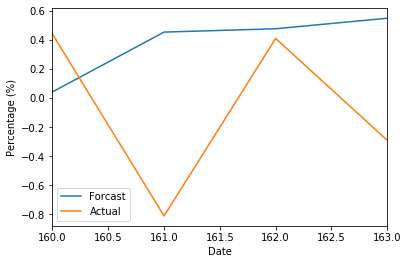

In [20]:
df_results['RETURNT1'+'_forecast'].plot()
df_test['RETURNT1'][-nobs:].plot()
plt.ylabel('Percentage (%)')
plt.xlabel('Date')
plt.legend(['Forcast', 'Actual'])
plt.show()

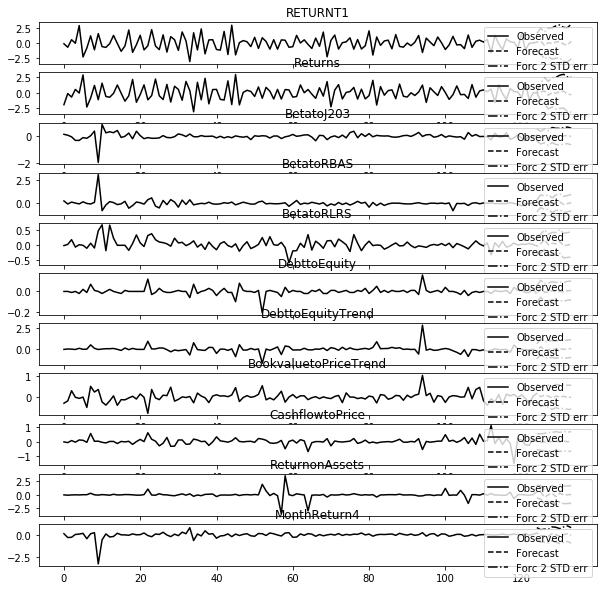

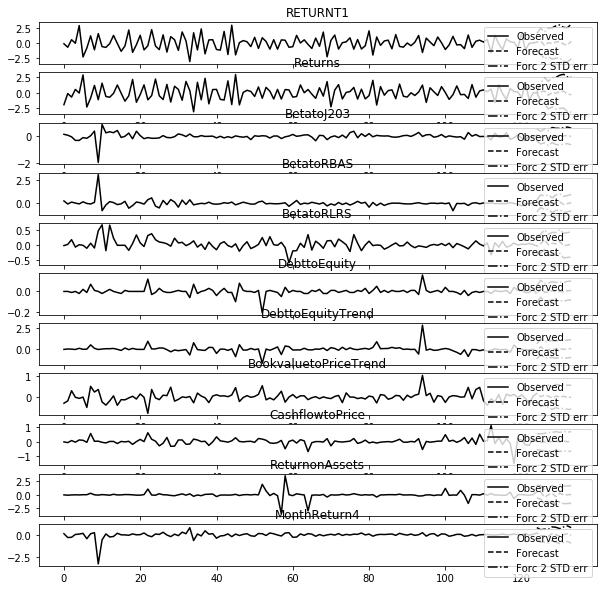

In [21]:
intoFuture = 10
model_fitted.plot_forecast(intoFuture)
